<a href="https://colab.research.google.com/github/rosadecsai/AccConExp/blob/main/AccConExp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The quality of a scientific manuscript given by a peer-reviewed report in three dimensions: Accessibility, Contribution and Experimentation (AccConExp)
In the notebook, we are going to code a machine based in deep learning (by using sciBERT) to learn three fundamental aspects Contribution, Accessibility, Experimentation and the corresponding sentiment.  This notebook is based on notebook in https://github.com/PrabhatkrBharti/Aspect-category-and-sentiment-extraction

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')





Mounted at /content/gdrive


In [5]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pickle


In [6]:

!pip install transformers
!pip install pytorch-transformers
!pip install -U sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In [7]:
import tensorflow as tf
from keras.layers import Bidirectional, Input, Dense, Layer, Dropout, LSTM, RepeatVector, Concatenate, Flatten,Conv2D
from keras.models import Sequential, Model
from tensorflow.python.keras.callbacks import EarlyStopping
from keras import backend as K



In [9]:
#  HYPERPARAMETERS
NUM_OF_CONSTRUCTS = 3 #ACCESSIBILITY, CONTRIBUTION and EXPERIMENTATION
NUM_OF_ASPECTS_ORI= 6 # CLA,SOU, ORI, MOT, SUB  CMP

EPOCHS = 150
MAXLEN = 768 # Since SciBERT returns 768 embeddings vector
LSTM_UNITS = 256
BATCH_SIZE =64



### **LOAD DATASET**




In [10]:
#change the path at your data
path_data='/content/gdrive/My Drive/Colab Notebooks/tesis_juanjo/Accesibilidad_Contribution_Reports/data'
n_out = path_data+'/data_augment.csv'
data=pd.read_csv(n_out,sep=',')
print(data.head())

print("Total Sentences ", len(data))
aux=data.query('CLA==1')
print("CLA ", aux['CLA'].sum())
print("SUB ", data.query('SUB==1')['SUB'].sum())
print("ORI ", data.query('ORI==1')['ORI'].sum())
print("MOT ", data.query('MOT==1')['MOT'].sum())
print("SUS ", data.query('SUB==1')['SUB'].sum())
print("CMP ", data.query('CMP==1')['CMP'].sum())
print("POS ", data.query('polarity==1')['polarity'].sum())
print("NEG ", data.query('polarity==-1')['polarity'].sum())


acce_pos = data.query('Accessibility==1 & polarity==1')
print("Accesibility_positive ",acce_pos['Accessibility'].sum())
acce_neg = data.query('Accessibility==1 & polarity==-1')
print("Accesibility_negative ",acce_neg['Accessibility'].sum())


con_pos = data.query('Contribution==1 & polarity==1')
print("Contribution_positive ",con_pos['Contribution'].sum())
con_neg = data.query('Contribution==1 & polarity==-1')
print("Contribution_negative ",con_neg['Contribution'].sum())

exp_pos = data.query('Experimentation==1 & polarity==1')
print("Experimentation_positive ",exp_pos['Experimentation'].sum())
exp_neg = data.query('Experimentation==1 & polarity==-1')
print("Experimentation_negative ",exp_neg['Experimentation'].sum())


   Unnamed: 0     review_ID  \
0           0   ICLR_2017_1   
1           1   ICLR_2017_1   
2           2   ICLR_2017_1   
3           3   ICLR_2017_1   
4           4  ICLR_2017_10   

                                              review  Accessibility  \
0  is a very interesting and fairly easy to read ...              1   
1                                               This              0   
2  What I like is that the idea is super simple a...              0   
3                                               This              0   
4                                the paper is poorly              1   

   Contribution  Experimentation  polarity  CLA  SOU  MOT  ORI  CMP  SUB  
0             0                0         1    1    0    0    0    0    0  
1             1                0         1    0    0    0    1    0    0  
2             1                0         1    0    0    0    1    0    0  
3             1                0         1    0    0    0    1    0    0  
4          

####  **SPLIT DATASET in Train and Test**
Define train and test set. Train 70% test 30%

In [11]:
from sklearn.model_selection import train_test_split

aspect_polarity=['Accessibility', 'Contribution','Experimentation','polarity']
aspect=['CLA','SOU','MOT','ORI','CMP','SUB']
x_train,x_test,y_train,y_test = train_test_split(data["review"],
data[aspect_polarity+aspect],test_size = 0.3, random_state=42)
train_data = pd.concat([x_train , y_train], axis = 1)
test_data = pd.concat([x_test , y_test], axis = 1)
train_data.head()





,review,Accessibility,Contribution,Experimentation,polarity,CLA,SOU,MOT,ORI,CMP,SUB
164459,I think all these clarifications will increase...,1,0,0,-1,1,0,0,0,0,0
66724,I found the paper to be clear and well written,1,0,0,1,1,0,0,0,0,0
133792,The writing and clarity of paper can be improv...,1,0,0,-1,1,0,0,0,0,0
85009,"while this is an interesting result , it seems...",1,0,0,-1,0,1,0,0,0,0
119224,this algorithm is very similar to W-GAN and th...,0,1,0,-1,0,0,0,1,0,0


In [12]:
aspect_cat= train_data.columns[1:4]
print(aspect_cat)

y_train=train_data[train_data.columns[1:]]
y_test=test_data[test_data.columns[1:]]
y_train['polarity']=y_train['polarity'].where(y_train['polarity']==1,0)
y_test['polarity']=y_test['polarity'].where(y_test['polarity']==1,0)
#print(test_data.head())
print(y_train.head())
print(y_test.head())


Index(['Accessibility', 'Contribution', 'Experimentation'], dtype='object')
        Accessibility  Contribution  Experimentation  polarity  CLA  SOU  MOT  \
164459              1             0                0         0    1    0    0   
66724               1             0                0         1    1    0    0   
133792              1             0                0         0    1    0    0   
85009               1             0                0         0    0    1    0   
119224              0             1                0         0    0    0    0   

        ORI  CMP  SUB  
164459    0    0    0  
66724     0    0    0  
133792    0    0    0  
85009     0    0    0  
119224    1    0    0  
        Accessibility  Contribution  Experimentation  polarity  CLA  SOU  MOT  \
113027              1             0                0         1    0    1    0   
162593              0             0                1         0    0    0    0   
23642               0             0               

<ipython-input-12-28ccf3ab5918>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train['polarity']=y_train['polarity'].where(y_train['polarity']==1,0)
<ipython-input-12-28ccf3ab5918>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['polarity']=y_test['polarity'].where(y_test['polarity']==1,0)


#### **Reading the reviews encoded by SciBert**

In [13]:

name_train_x_out = path_data+'/sci_emb_train.pkl'
name_test_x_out = path_data+'/sci_emb_test.pkl'

with open(name_train_x_out, 'rb') as df_file_train:
  sci_embeds_train= pickle.load(df_file_train)
with open(name_test_x_out, 'rb') as df_file_test:
  sci_embeds_test= pickle.load(df_file_test)

train_embeds = sci_embeds_train['x']
test_embeds = sci_embeds_test['x']


In [14]:
train_embeds.shape , y_train.shape

((120926, 1, 768), (120926, 10))

In [15]:
test_embeds.shape , y_test.shape

((51826, 1, 768), (51826, 10))

# **Proposed Architecture (AccConExp)**
**Attention Layer**

In [16]:
class Attention(Layer):

    def __init__(self, return_sequences=True, **kwargs):
        super(Attention,self).__init__()
        self.return_sequences = return_sequences
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super(Attention, self).get_config().copy()
        config.update({
            'return_sequences': self.return_sequences ,
        })
        return config


    def build(self, input_shape):

        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

        super(Attention,self).build(input_shape)

    def call(self, x):
        e =K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        a =K.softmax(e)
        a=K.expand_dims(a,axis=-1)
        output = x*a

        return K.sum(output, axis=1)

### **MODEL AccConExp (First)**: Learn Construct Categories and Sentiment
This model will tagger evey sentence by using Accessibility, Contribution or Experimentation construct and also polarity (negative or positive sentiment). Based over this first part in the second part we will learn aspect-categories.

In [17]:

#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)

#for every aspect in (Accessibility, Contribution, Experimentation) add an attention layer
attentions=[]
for i in range(NUM_OF_CONSTRUCTS):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)

flatten = Flatten()(concate_attention)


# BRANCH 1: classify Accessibility, Contribution and Experimentation
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)

category_output = Dense(NUM_OF_CONSTRUCTS, activation='softmax', name='CATEGORY_OUTPUT')(b1_x)

# BRANCH 2 classify Polarity
dense2 =  Dense(60, activation='relu', name='SENTIMENT_DENSE')(flatten)
polarity_output = Dense(1, activation='sigmoid', name='SENTIMENT_OUTPUT')(dense2)

AccConExp_Part1 = Model(inputs=embed, outputs=[category_output, polarity_output])





In [18]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT': 'categorical_crossentropy',
         'SENTIMENT_OUTPUT': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT': 1.0,
                'SENTIMENT_OUTPUT': 1.0
              }


AccConExp_Part1.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam',
                        metrics=['accuracy'])


AccConExp_Part1.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector (RepeatVecto  (None, 1, 512)               0         ['BILSTM[0][0]']              
 r)                                                                                               
                                                                                                  
 attention_1 (Attention)     (None, 512)                  513       ['repeat_vector[0][0]']   

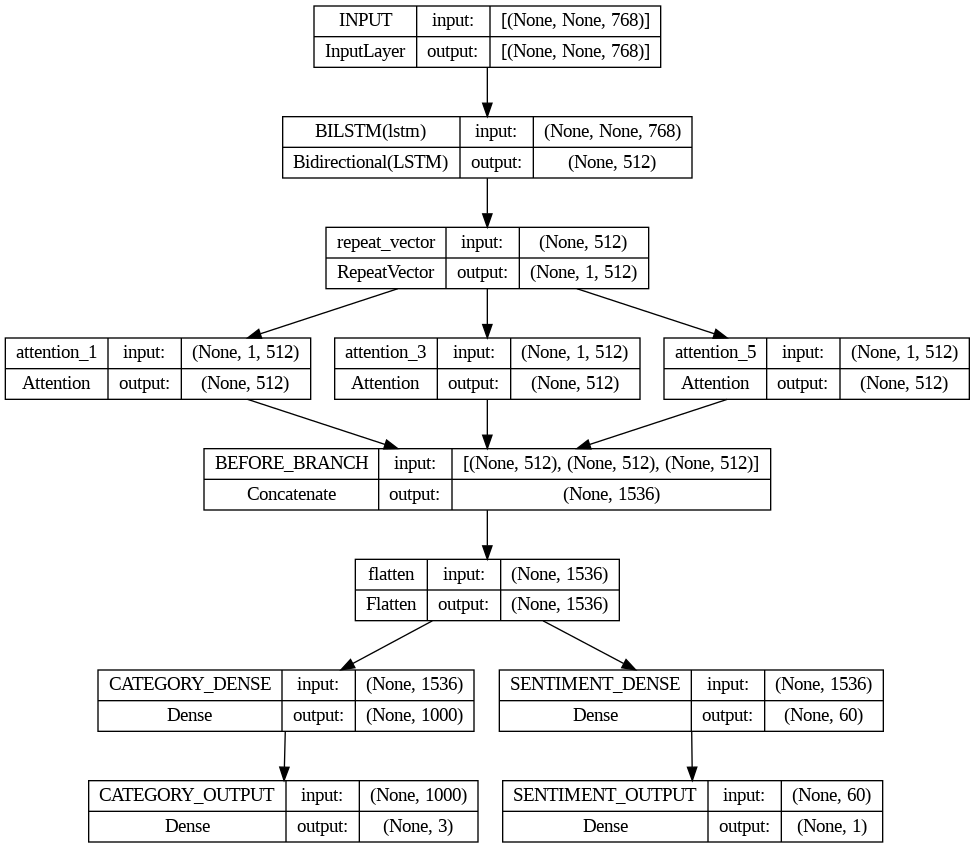

In [19]:
tf.keras.utils.plot_model(AccConExp_Part1, to_file='AccConExp_Part1.png', show_shapes=True)


#### FIT  AccConExp (First) MODEL

In [20]:

history = AccConExp_Part1.fit(
                          train_embeds,
                          y =  {
                          'CATEGORY_OUTPUT': y_train[aspect_cat].values,
                          'SENTIMENT_OUTPUT': y_train.polarity.values

                          },
                           validation_data = (test_embeds, {
                          'CATEGORY_OUTPUT': y_test[aspect_cat].values,
                          'SENTIMENT_OUTPUT': y_test.polarity.values
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                           batch_size=BATCH_SIZE,
                           callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/AccConExp-ModelPart1.h5'
AccConExp_Part1.save(SAVE_PATH, overwrite=True, save_format="tf")
print("Weights Saved")

Epoch 1/150
1890/1890 - 21s - loss: 0.7028 - CATEGORY_OUTPUT_loss: 0.5221 - SENTIMENT_OUTPUT_loss: 0.1807 - CATEGORY_OUTPUT_accuracy: 0.7807 - SENTIMENT_OUTPUT_accuracy: 0.9255 - val_loss: 0.6084 - val_CATEGORY_OUTPUT_loss: 0.4612 - val_SENTIMENT_OUTPUT_loss: 0.1472 - val_CATEGORY_OUTPUT_accuracy: 0.8094 - val_SENTIMENT_OUTPUT_accuracy: 0.9379 - lr: 0.0010 - 21s/epoch - 11ms/step
Epoch 2/150
1890/1890 - 13s - loss: 0.5918 - CATEGORY_OUTPUT_loss: 0.4424 - SENTIMENT_OUTPUT_loss: 0.1494 - CATEGORY_OUTPUT_accuracy: 0.8182 - SENTIMENT_OUTPUT_accuracy: 0.9385 - val_loss: 0.5596 - val_CATEGORY_OUTPUT_loss: 0.4215 - val_SENTIMENT_OUTPUT_loss: 0.1380 - val_CATEGORY_OUTPUT_accuracy: 0.8283 - val_SENTIMENT_OUTPUT_accuracy: 0.9436 - lr: 0.0010 - 13s/epoch - 7ms/step
Epoch 3/150
1890/1890 - 13s - loss: 0.5556 - CATEGORY_OUTPUT_loss: 0.4159 - SENTIMENT_OUTPUT_loss: 0.1397 - CATEGORY_OUTPUT_accuracy: 0.8294 - SENTIMENT_OUTPUT_accuracy: 0.9428 - val_loss: 0.5565 - val_CATEGORY_OUTPUT_loss: 0.4208 - va

In [21]:
# LOAD MODEL
from keras.models import load_model
#change path_data to your  data folder
path_data='/content/gdrive/My Drive/Colab Notebooks/tesis_juanjo/Accesibilidad_Contribution_Reports/data'
LOAD_PATH=path_data+'/AccConExp-ModelPart1.h5'
AccConExp_Part1 = load_model(LOAD_PATH, custom_objects={'Attention': Attention})

print("MODEL LOADED\n\n")

AccConExp_Part1.evaluate(test_embeds, [y_test[aspect_cat].values, y_test.polarity.values] )

MODEL LOADED


1620/1620 [==============================] - 6s 3ms/step - loss: 0.6396 - CATEGORY_OUTPUT_loss: 0.4964 - SENTIMENT_OUTPUT_loss: 0.1432 - CATEGORY_OUTPUT_accuracy: 0.9329 - SENTIMENT_OUTPUT_accuracy: 0.9760


[0.6395744681358337,
 0.4963785707950592,
 0.14319591224193573,
 0.9328715205192566,
 0.9760159254074097]

### **AccConExp (First) MODEL:** VALIDATION


In [22]:
categories = y_train.columns[:3]
polarity_labels = ['POSITIVE', 'NEGATIVE']

In [23]:
# Construct CATEGORY: Accessibility, Contribution, Experiment
# Also Sentiement (positive and negative)
y_pred_aspect = AccConExp_Part1.predict(test_embeds)
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]

y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_test[aspect_cat].values, axis=1)


1620/1620 [==============================] - 5s 2ms/step


In [24]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_aspect_idx)
cm_polarity = cm(y_test.polarity.values, y_pred_polarity)

In [25]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect_cat, aspect_acc):
    print('',cat,"\t",round(acc, 3))

# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE ACCURACY : **** 

CLASS	ACCURACY
 Accessibility 	 0.903
 Contribution 	 0.946
 Experimentation 	 0.95


*** POLARITY ACCURACY : **** 

CLASS		ACCURACY
POSITIVE 	 0.977
NEGATIVE 	 0.975


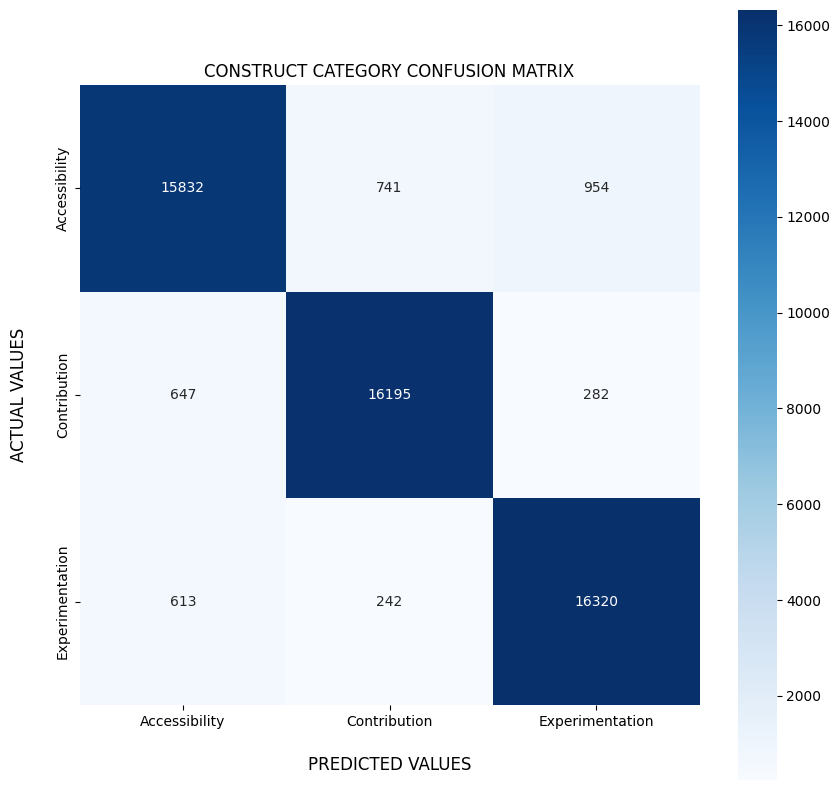

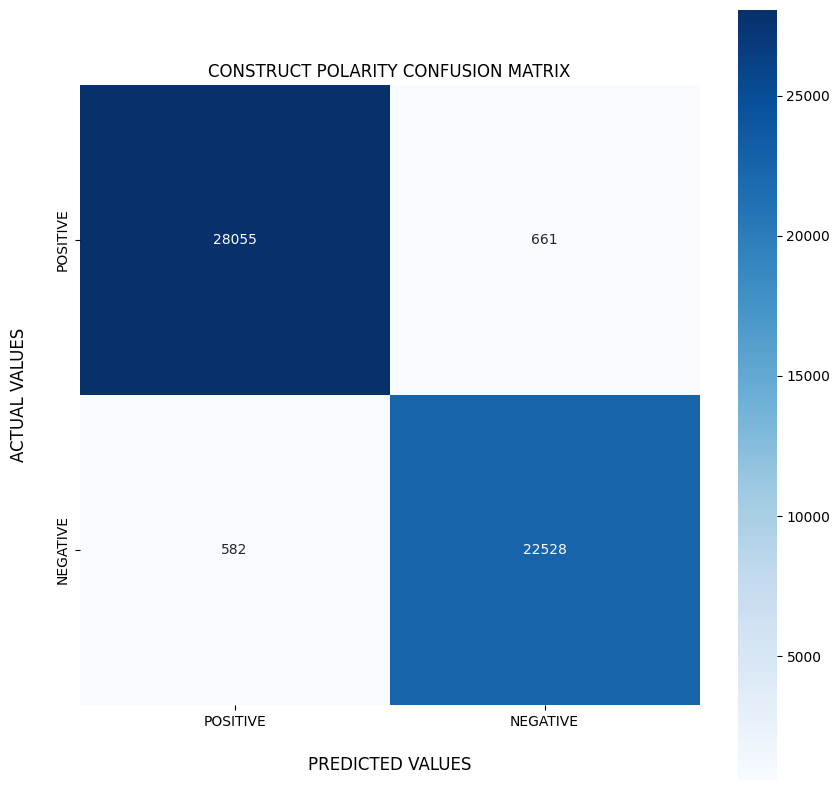

In [26]:

plt.figure(figsize=(10, 10))

sns.heatmap(cm_aspect, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=categories, xticklabels=categories)
plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('CONSTRUCT CATEGORY CONFUSION MATRIX')
plt.savefig(path_data+'/'+"CM_ACC_CON_EXP.png")
plt.show()
plt.close()
plt.figure(figsize=(10, 10))
sns.heatmap(cm_polarity, square=True, annot=True, cmap='Blues', fmt='d', cbar=True, yticklabels=polarity_labels, xticklabels=polarity_labels)
plt.xlabel('PREDICTED VALUES', fontsize=12, labelpad=20)
plt.ylabel('ACTUAL VALUES', fontsize=12, labelpad=20)
plt.title('CONSTRUCT POLARITY CONFUSION MATRIX')
plt.savefig(path_data+'/CM_POLARITY_ACC_CON_EXP.png')
plt.show()
plt.close()

In [27]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
print(classification_report(y_test_idx, y_pred_aspect_idx, target_names=categories))
print('\n\n',classification_report(y_test.polarity.values, y_pred_polarity, target_names=polarity_labels))

                 precision    recall  f1-score   support

  Accessibility       0.93      0.90      0.91     17527
   Contribution       0.94      0.95      0.94     17124
Experimentation       0.93      0.95      0.94     17175

       accuracy                           0.93     51826
      macro avg       0.93      0.93      0.93     51826
   weighted avg       0.93      0.93      0.93     51826



               precision    recall  f1-score   support

    POSITIVE       0.98      0.98      0.98     28716
    NEGATIVE       0.97      0.97      0.97     23110

    accuracy                           0.98     51826
   macro avg       0.98      0.98      0.98     51826
weighted avg       0.98      0.98      0.98     51826



## **INFERENCE MODEL**

In [28]:
from transformers import pipeline, AutoTokenizer, AutoModel

In [29]:
## SCIBERT
embed_model_name = 'gsarti/scibert-nli'

In [30]:
tokenizer = AutoTokenizer.from_pretrained(embed_model_name)
embed_model = AutoModel.from_pretrained(embed_model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/450 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [31]:
def sent2embed(model, sent):
    inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    return outputs

#example
sent = train_data.loc[train_data.index[0],'review']
outputs = sent2embed(embed_model, sent)
outputs[1].shape


torch.Size([1, 768])

In [32]:
def predictPreprocess(model, sent):
  outputs = sent2embed(model, sent)
  pred_X = np.array([outputs[1].detach().numpy()[0]])
  embed_X = tf.stack(pred_X)
  return embed_X

In [33]:
def inferenceModel(multi_model, embed_model, sent,labels):
    #labels = y_train.columns[:-1]

    sents= sent.split('.')[:-1]
    results =[]
    for s in sents:
        test_embed = predictPreprocess(embed_model, s.strip()).numpy()
        test_embed=np.expand_dims(test_embed, axis=0)
        print(test_embed.shape)
        category_probab = multi_model.predict([test_embed])
        category_label_idx = np.argmax(category_probab[0])
        category_polarity = 1 if category_probab[1][0][0] > 0.5 else 0
        category_label = 'POS' if category_probab[1][0][0] > 0.5 else 'NEG'
        results.append([labels[category_label_idx] , category_polarity, category_label])

    return results


In [34]:
# LOAD MODEL
from keras.models import load_model
LOAD_PATH=path_data+'/AccConExp-ModelPart1.h5'
AccConExp_Part1 = load_model(LOAD_PATH, custom_objects={'Attention': Attention})
# SAMPLE 1
sent = '''This paper presents a model-free policy gradient approach for reinforcement learning that combines on-policy
updates with an off-policy critic . The hope is to learn continuous control in a sample-efficient fashion . The approach
is validated on a number of low-dimensional continuous control tasks in a simulated environment .'''
op = inferenceModel(AccConExp_Part1,embed_model, sent,aspect_cat)

print('PREDICTED OUTPUT :', op)

(1, 1, 768)
1/1 [==============================] - 1s 749ms/step
(1, 1, 768)
1/1 [==============================] - 0s 18ms/step
(1, 1, 768)
1/1 [==============================] - 0s 18ms/step
PREDICTED OUTPUT : [['Contribution', 1, 'POS'], ['Accessibility', 0, 'NEG'], ['Experimentation', 1, 'POS']]


In [35]:
# SAMPLE 2
sent = '''However , since the processing of sequential data seems to be a broad and general area of application , it is
conceivable that this work will be useful in the design and application of future CNNs . All in all , this paper introduces
an interesting idea to address an important topic .'''
op = inferenceModel(AccConExp_Part1,embed_model, sent,aspect_cat)

print('PREDICTED OUTPUT :', op)

(1, 1, 768)
1/1 [==============================] - 0s 19ms/step
(1, 1, 768)
1/1 [==============================] - 0s 18ms/step
PREDICTED OUTPUT : [['Contribution', 1, 'POS'], ['Contribution', 1, 'POS']]


In [36]:
print(aspect)

['CLA', 'SOU', 'MOT', 'ORI', 'CMP', 'SUB']


###***AccConExp (Second) MODEL***
 In this case we training a deep machine for every construct. Thus, we can distinguish between the aspect-categories with a construct.

####**AccConExp (Second) Model** Accessibility Machine. Preprocessig Data  

In [38]:
#select only data with accessibility label
#get the index

train_acce= train_data.query("Accessibility==1")
test_acce= test_data.query("Accessibility==1")
train_index_pos = dict({r:pos for pos,r in enumerate(train_data.index)})
test_index_pos = dict({r:pos for pos,r in enumerate(test_data.index)})

train_embd_acce =[]
for k in train_acce.index:
  train_embd_acce.append(train_embeds[train_index_pos[k],:,:])

train_embd_acce = np.array(train_embd_acce)


test_embd_acce =[]
for k in test_acce.index:
  test_embd_acce.append(test_embeds[test_index_pos[k],:,:])

test_embd_acce = np.array(test_embd_acce)


y_train_acc=train_acce[train_acce.columns[1:]]
y_test_acc=test_acce[test_acce.columns[1:]]
y_train_acc['polarity']=y_train_acc['polarity'].where(y_train_acc['polarity']==1,0)
y_test_acc['polarity']=y_test_acc['polarity'].where(y_test_acc['polarity']==1,0)

print(train_acce.head())


                                                   review  Accessibility  \
164459  I think all these clarifications will increase...              1   
66724      I found the paper to be clear and well written              1   
133792  The writing and clarity of paper can be improv...              1   
85009   while this is an interesting result , it seems...              1   
110843  without which the approach has very limited pr...              1   

        Contribution  Experimentation  polarity  CLA  SOU  MOT  ORI  CMP  SUB  
164459             0                0        -1    1    0    0    0    0    0  
66724              0                0         1    1    0    0    0    0    0  
133792             0                0        -1    1    0    0    0    0    0  
85009              0                0        -1    0    1    0    0    0    0  
110843             0                0        -1    0    1    0    0    0    0  


<ipython-input-38-4f448833c273>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_acc['polarity']=y_train_acc['polarity'].where(y_train_acc['polarity']==1,0)
<ipython-input-38-4f448833c273>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_acc['polarity']=y_test_acc['polarity'].where(y_test_acc['polarity']==1,0)


####**AccConExp (Second) Model** Accessibility Machine. Architecture

In [39]:

#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)


attentions=[]
for i in range(0,2):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)
flatten = Flatten()(concate_attention)

b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(2, activation='softmax', name='CATEGORY_OUTPUT_acc')(b1_x)


model_acc = Model(inputs=embed, outputs=category_output)



In [40]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT_acc': 'categorical_crossentropy',
       }



model_acc.compile(loss= loss,
                        optimizer='adam',
                        metrics=['accuracy'])


model_acc.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_1 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_13 (Attention)    (None, 512)                  513       ['repeat_vector_1[0][0]'

In [41]:
asp=['CLA','SOU']
history = model_acc.fit(
                          train_embd_acce,
                          y =  {
                          'CATEGORY_OUTPUT_acc': y_train_acc[asp].values,
                          },
                           validation_data = (test_embd_acce, {
                          'CATEGORY_OUTPUT_acc': y_test_acc[asp].values,
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                           batch_size=64,
                           callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/Accessibility_Aspects.h5'

model_acc.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/150
626/626 - 8s - loss: 0.2868 - accuracy: 0.8748 - val_loss: 0.2478 - val_accuracy: 0.8926 - lr: 0.0010 - 8s/epoch - 13ms/step
Epoch 2/150
626/626 - 4s - loss: 0.2336 - accuracy: 0.9017 - val_loss: 0.2141 - val_accuracy: 0.9103 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 3/150
626/626 - 4s - loss: 0.2199 - accuracy: 0.9091 - val_loss: 0.2049 - val_accuracy: 0.9147 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 4/150
626/626 - 4s - loss: 0.2079 - accuracy: 0.9141 - val_loss: 0.1965 - val_accuracy: 0.9211 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 5/150
626/626 - 4s - loss: 0.1952 - accuracy: 0.9179 - val_loss: 0.1961 - val_accuracy: 0.9200 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 6/150
626/626 - 4s - loss: 0.1901 - accuracy: 0.9223 - val_loss: 0.1907 - val_accuracy: 0.9233 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 7/150
626/626 - 4s - loss: 0.1795 - accuracy: 0.9263 - val_loss: 0.1931 - val_accuracy: 0.9209 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 8/150
626/626 - 4s - loss: 0.1719 - accur

### **AccConExp (Second) Model** Contribution Machine. Architecture
####Select Contribution Sentences

In [ ]:
#select only data with contribution label
#get the index
print(train_data.head())
train_con= train_data.query("Contribution==1")
test_con= test_data.query("Contribution==1")
train_index_pos = dict({r:pos for pos,r in enumerate(train_data.index)})
test_index_pos = dict({r:pos for pos,r in enumerate(test_data.index)})
print(train_embeds.shape)
train_embd_con =[]
for k in train_con.index:
#select only data with contribution label
#get the index

train_con= train_data.query("Contribution==1")
test_con= test_data.query("Contribution==1")
train_index_pos = dict({r:pos for pos,r in enumerate(train_data.index)})
test_index_pos = dict({r:pos for pos,r in enumerate(test_data.index)})

train_embd_con =[]
for k in train_con.index:
  train_embd_con.append(train_embeds[train_index_pos[k],:,:])

train_embd_con = np.array(train_embd_con)
print(train_embd_con.shape)

test_embd_con =[]
for k in test_con.index:
  test_embd_con.append(test_embeds[test_index_pos[k],:,:])

test_embd_con = np.array(test_embd_con)
print(test_embd_con.shape)

y_train_con=train_con[train_con.columns[1:]]
y_test_con=test_con[test_con.columns[1:]]
y_train_con['polarity']=y_train_con['polarity'].where(y_train_con['polarity']==1,0)
y_test_con['polarity']=y_test_con['polarity'].where(y_test_con['polarity']==1,0)


print(train_con.head())


                                                   review  Accessibility  \
164459  I think all these clarifications will increase...              1   
66724      I found the paper to be clear and well written              1   
133792  The writing and clarity of paper can be improv...              1   
85009   while this is an interesting result , it seems...              1   
119224  this algorithm is very similar to W-GAN and th...              0   

        Contribution  Experimentation  polarity  CLA  SOU  MOT  ORI  CMP  SUB  
164459             0                0        -1    1    0    0    0    0    0  
66724              0                0         1    1    0    0    0    0    0  
133792             0                0        -1    1    0    0    0    0    0  
85009              0                0        -1    0    1    0    0    0    0  
119224             1                0        -1    0    0    0    1    0    0  
(120926, 1, 768)
(40460, 1, 768)
(17124, 1, 768)
              

<ipython-input-11-30b2de23fdca>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_con['polarity']=y_train_con['polarity'].where(y_train_con['polarity']==1,0)
<ipython-input-11-30b2de23fdca>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_con['polarity']=y_test_con['polarity'].where(y_test_con['polarity']==1,0)


#### Architecture

In [ ]:

#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)


attentions=[]
for i in range(0,2):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)
flatten = Flatten()(concate_attention)
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(2, activation='softmax', name='CATEGORY_OUTPUT_con')(b1_x)


model_con = Model(inputs=embed, outputs=category_output)



In [ ]:
from keras.callbacks import ReduceLROnPlateau
metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT_con': 'categorical_crossentropy',
       }



model_con.compile(loss= loss,
                        optimizer='adam',
                        metrics=['accuracy'])
model_con.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_2 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_9 (Attention)     (None, 512)                  513       ['repeat_vector_2[0][0]'

In [ ]:
asp=['ORI','MOT']
history =model_con.fit(
                          train_embd_con,
                          y =  {
                          'CATEGORY_OUTPUT_con': y_train_con[asp].values,
                          },
                           validation_data = (test_embd_con, {
                          'CATEGORY_OUTPUT_con': y_test_con[asp].values,
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                           batch_size=64,
                           callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/Contribution_Aspects.h5'

model_con.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/150
633/633 - 9s - loss: 0.3735 - accuracy: 0.8291 - val_loss: 0.3253 - val_accuracy: 0.8531 - lr: 0.0010 - 9s/epoch - 14ms/step
Epoch 2/150
633/633 - 4s - loss: 0.3131 - accuracy: 0.8578 - val_loss: 0.2952 - val_accuracy: 0.8634 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 3/150
633/633 - 4s - loss: 0.2942 - accuracy: 0.8659 - val_loss: 0.2925 - val_accuracy: 0.8681 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 4/150
633/633 - 4s - loss: 0.2780 - accuracy: 0.8745 - val_loss: 0.3166 - val_accuracy: 0.8532 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 5/150
633/633 - 4s - loss: 0.2654 - accuracy: 0.8820 - val_loss: 0.2847 - val_accuracy: 0.8776 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 6/150
633/633 - 4s - loss: 0.2497 - accuracy: 0.8879 - val_loss: 0.2542 - val_accuracy: 0.8868 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 7/150
633/633 - 4s - loss: 0.2393 - accuracy: 0.8943 - val_loss: 0.2613 - val_accuracy: 0.8849 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 8/150
633/633 - 4s - loss: 0.2209 - accur

####**AccConExp (Second) Model** Experimentation Machine. Architecture
##### Select sentences

In [ ]:
#select only data with experimentatin label
#get the index

train_exp= train_data.query("Experimentation==1")
test_exp= test_data.query("Experimentation==1")
train_index_pos = dict({r:pos for pos,r in enumerate(train_data.index)})
test_index_pos = dict({r:pos for pos,r in enumerate(test_data.index)})
print(train_embeds.shape)
train_embd_exp =[]
for k in train_exp.index:
  train_embd_exp.append(train_embeds[train_index_pos[k],:,:])

train_embd_exp = np.array(train_embd_exp)
print(train_embd_exp.shape)

test_embd_exp =[]
for k in test_exp.index:
  test_embd_exp.append(test_embeds[test_index_pos[k],:,:])

test_embd_exp = np.array(test_embd_exp)


y_train_exp=train_exp[train_exp.columns[1:]]
y_test_exp=test_exp[test_exp.columns[1:]]
y_train_exp['polarity']=y_train_exp['polarity'].where(y_train_exp['polarity']==1,0)
y_test_exp['polarity']=y_test_exp['polarity'].where(y_test_exp['polarity']==1,0)


print(train_exp.head())


                                                   review  Accessibility  \
164459  I think all these clarifications will increase...              1   
66724      I found the paper to be clear and well written              1   
133792  The writing and clarity of paper can be improv...              1   
85009   while this is an interesting result , it seems...              1   
119224  this algorithm is very similar to W-GAN and th...              0   

        Contribution  Experimentation  polarity  CLA  SOU  MOT  ORI  CMP  SUB  
164459             0                0        -1    1    0    0    0    0    0  
66724              0                0         1    1    0    0    0    0    0  
133792             0                0        -1    1    0    0    0    0    0  
85009              0                0        -1    0    1    0    0    0    0  
119224             1                0        -1    0    0    0    1    0    0  
(120926, 1, 768)
(40409, 1, 768)
(17175, 1, 768)
              

<ipython-input-23-ba7cfa72b3db>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_exp['polarity']=y_train_exp['polarity'].where(y_train_exp['polarity']==1,0)
<ipython-input-23-ba7cfa72b3db>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_exp['polarity']=y_test_exp['polarity'].where(y_test_exp['polarity']==1,0)


### Architecture

In [ ]:

#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)


attentions=[]
for i in range(0,2):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)
flatten = Flatten()(concate_attention)


b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(2, activation='softmax', name='CATEGORY_OUTPUT_exp')(b1_x)


model_exp = Model(inputs=embed, outputs=category_output)



In [ ]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT_exp': 'categorical_crossentropy',

       }

model_exp.compile(loss= loss,
                        optimizer='adam',
                        metrics=['accuracy'])


model_exp.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_3 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_13 (Attention)    (None, 512)                  513       ['repeat_vector_3[0][0]'

In [ ]:
asp=['SUB','CMP']
history =model_exp.fit(
                          train_embd_exp,
                          y =  {
                          'CATEGORY_OUTPUT_exp': y_train_exp[asp].values,
                          },
                           validation_data = (test_embd_exp, {
                          'CATEGORY_OUTPUT_exp': y_test_exp[asp].values,
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                           batch_size=64,
                           callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/Experimentation_Aspects.h5'

model_exp.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/150
632/632 - 9s - loss: 0.4049 - accuracy: 0.8152 - val_loss: 0.3510 - val_accuracy: 0.8480 - lr: 0.0010 - 9s/epoch - 14ms/step
Epoch 2/150
632/632 - 4s - loss: 0.3301 - accuracy: 0.8557 - val_loss: 0.3339 - val_accuracy: 0.8553 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 3/150
632/632 - 4s - loss: 0.2990 - accuracy: 0.8702 - val_loss: 0.2874 - val_accuracy: 0.8784 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 4/150
632/632 - 4s - loss: 0.2780 - accuracy: 0.8801 - val_loss: 0.2967 - val_accuracy: 0.8732 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 5/150
632/632 - 4s - loss: 0.2633 - accuracy: 0.8866 - val_loss: 0.2663 - val_accuracy: 0.8859 - lr: 0.0010 - 4s/epoch - 7ms/step
Epoch 6/150
632/632 - 4s - loss: 0.2439 - accuracy: 0.8982 - val_loss: 0.2897 - val_accuracy: 0.8810 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 7/150
632/632 - 4s - loss: 0.2267 - accuracy: 0.9072 - val_loss: 0.2520 - val_accuracy: 0.8974 - lr: 0.0010 - 4s/epoch - 6ms/step
Epoch 8/150
632/632 - 4s - loss: 0.2129 - accur

####**AccConExp (Second) Model**
### CONSTRUCT-CATEGORY ASPECT-CATEGORY and POLARITY

In [42]:
from keras.models import load_model
#Load the different models
LOAD_PATH =path_data+'/AccConExp-ModelPart1.h5'
model_Construct = load_model(LOAD_PATH, custom_objects={'Attention': Attention})
models_aspects=[]
LOAD_PATH=path_data+'/Accessibility_Aspects.h5'
models_aspects.append(load_model(LOAD_PATH, custom_objects={'Attention': Attention}))
LOAD_PATH=path_data+'/Contribution_Aspects.h5'
models_aspects.append(load_model(LOAD_PATH, custom_objects={'Attention': Attention}))
LOAD_PATH=path_data+'/Experimentation_Aspects.h5'
models_aspects.append(load_model(LOAD_PATH, custom_objects={'Attention': Attention}))

In [43]:
aspect_cat= train_data.columns[1:4]
print(aspect)
print(aspect_cat)

['CLA', 'SOU', 'MOT', 'ORI', 'CMP', 'SUB']
Index(['Accessibility', 'Contribution', 'Experimentation'], dtype='object')


In [44]:
# ASPECT CATEGORY
categories = y_train.columns[:3]
polarity_labels = ['POSITIVE', 'NEGATIVE']
aspects=['CLA','ORI','ORI','MOT','SUB','CMP']
ACC_cat=['CLA','SOU']
#dict_keys=[dict('CLA':0,'SOU':1),dict('ORI':3,'MOT':2),dic('SUB':5,'CMP':4)]
dict_keys=[dict({0:0,1:1}),dict({0:3,1:2}),dict({0:5,1:4})]
CON_cat=['ORI','MOT']
EXP_cat=['SUB','CMP']
#Tagger by Accessibility, Contribution and Experimentation. Also polarity
y_pred_aspect = model_Construct.predict(test_embeds)
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]
y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_test[aspect_cat].values, axis=1)


y_pred_final=np.zeros((len(test_embeds,)),dtype=int)
y_test_idx =np.argmax(y_test[aspect].values, axis=1)
cons_acc = [i for i in range(0,len(y_pred_aspect_idx)) if y_pred_aspect_idx[i]==0]
cons_con = [i for i in range(0,len(y_pred_aspect_idx)) if y_pred_aspect_idx[i]==1]
cons_exp = [i for i in range(0,len(y_pred_aspect_idx)) if y_pred_aspect_idx[i]==2]
#setences with accessibility
embds_acc=test_embeds[cons_acc]
#setences with contribution
embds_con=test_embeds[cons_con]
#setences with experimentation
embds_exp=test_embeds[cons_exp]

#ACCESSIBILITY-->CLA and SOU
sub_y_pred_categories=models_aspects[0].predict(embds_acc)
sub_y_pred_aspect_idx = np.argmax(sub_y_pred_categories, axis=1)
j=0
for i in cons_acc:
  y_pred_final[i]=dict_keys[0][sub_y_pred_aspect_idx[j]]
  j+=1

#CONTRIBUTION-->ORI and MOT
sub_y_pred_categories=models_aspects[1].predict(embds_con)
sub_y_pred_aspect_idx = np.argmax(sub_y_pred_categories, axis=1)
j=0
for i in cons_con:
  y_pred_final[i]=dict_keys[1][sub_y_pred_aspect_idx[j]]
  j+=1

#EXPERIMENTATION-->SUB and CMP
sub_y_pred_categories=models_aspects[2].predict(embds_exp)
sub_y_pred_aspect_idx = np.argmax(sub_y_pred_categories, axis=1)
j=0
for i in cons_exp:
  y_pred_final[i]=dict_keys[2][sub_y_pred_aspect_idx[j]]
  j+=1


549/549 [==============================] - 2s 2ms/step


In [45]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_final)
cm_polarity = cm(y_test.polarity.values, y_pred_polarity)

In [46]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect, aspect_acc):
    print('',cat,"\t",round(acc, 3))

# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE ACCURACY : **** 

CLASS	ACCURACY
 CLA 	 0.915
 SOU 	 0.816
 MOT 	 0.916
 ORI 	 0.911
 CMP 	 0.956
 SUB 	 0.899


*** POLARITY ACCURACY : **** 

CLASS		ACCURACY
POSITIVE 	 0.977
NEGATIVE 	 0.975


In [47]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
import keras
print(classification_report(y_test_idx, y_pred_final, target_names=aspect))
print('\n\n',classification_report(y_test.polarity.values, y_pred_polarity, target_names=polarity_labels))


              precision    recall  f1-score   support

         CLA       0.93      0.92      0.92      8886
         SOU       0.84      0.82      0.83      8641
         MOT       0.90      0.92      0.91      8610
         ORI       0.92      0.91      0.91      8514
         CMP       0.93      0.96      0.94      8571
         SUB       0.88      0.90      0.89      8604

    accuracy                           0.90     51826
   macro avg       0.90      0.90      0.90     51826
weighted avg       0.90      0.90      0.90     51826



               precision    recall  f1-score   support

    POSITIVE       0.98      0.98      0.98     28716
    NEGATIVE       0.97      0.97      0.97     23110

    accuracy                           0.98     51826
   macro avg       0.98      0.98      0.98     51826
weighted avg       0.98      0.98      0.98     51826



In [ ]:
#Some Correct Examples
#Examples construct and aspect

pd.options.display.max_colwidth = 150
pos_acc_sou=np.argwhere(y_pred_final==1).reshape(-1)
pos_acc_sou_neg=[i for i in pos_acc_sou if y_pred_polarity[i]==0]
print("Sentences CON+NEG", len(pos_acc_sou_neg))
name_out = path_data+'/sen_acc_sou_neg.txt'
print("Writting ",name_out)
f=open(name_out,'wt')
for i in pos_acc_sou_neg:
  if (y_test_idx[i]== y_pred_final[i] and y_test.polarity.values[i]==y_pred_polarity[i]):
    f.write(test_data.loc[test_data.index[i],'review']+'\n')
f.close()

Sentences CON+NEG 4450
Writting  /content/gdrive/My Drive/Colab Notebooks/tesis_juanjo/Accesibilidad_Contribution_Reports/data/sen_acc_sou_neg.txt


In [ ]:
#Some Wrong Examples
#Examples construct and aspect

pd.options.display.max_colwidth = 150
pos_acc_cla=np.argwhere(y_pred_final==0).reshape(-1)
pos_acc_cla_pos=[i for i in pos_acc_cla if y_pred_polarity[i]==1]
print("Sentences CON+NEG", len(pos_acc_cla_pos))
name_out = path_data+'/sen_wrong_acc_cla_pos.txt'
print("Writting ",name_out)
f=open(name_out,'wt')
for i in pos_acc_cla_pos:
  if (y_test_idx[i]!= y_pred_final[i] or y_test.polarity.values[i]!=y_pred_polarity[i]):
    p=" POS"
    if (y_test.polarity.values[i]==0):
      p=" NEG"

    f.write(test_data.loc[test_data.index[i],'review']+"-->"+aspect[y_test_idx[i]]+p+'\n')
f.close()

Sentences CON+NEG 3919
Writting  /content/gdrive/My Drive/Colab Notebooks/tesis_juanjo/Accesibilidad_Contribution_Reports/data/sen_wrong_acc_cla_pos.txt


# COMPARISON: BASE MODEL

In [48]:
#MODEL BASE classify aspect+polarity
#For default embd ha dimension (_,768)
embed = Input(shape=  (None, MAXLEN), name='INPUT')
#bidirectional long short term memory
#in forward 256 units and backward 256 units in total 512 units
biLSTM = Bidirectional(LSTM(LSTM_UNITS , return_sequences=False) , name='BILSTM' )(embed)
#add a new dimension (batch_size,len)-->(batch_size,1,len) (_,512)-->(_,1,512)
repeat_op = RepeatVector(1)(biLSTM)

#for every aspect in (CLA,SOU,ORI,MOT,SUB,CMP) add an attention layer
attentions=[]
for i in range(NUM_OF_ASPECTS_ORI):
  x = Attention(return_sequences=False)(repeat_op)
  attentions.append(x)
#concatena all the outputs
concate_attention  = Concatenate(name='BEFORE_BRANCH')(attentions)
flatten = Flatten()(concate_attention)

# BRANCH 1: classify (CLA,SOU,ORI,MOT,SUB,CMP)
b1_x =  Dense(1000, activation='relu', name='CATEGORY_DENSE')(flatten)
category_output = Dense(NUM_OF_ASPECTS_ORI, activation='softmax', name='CATEGORY_OUTPUT_base')(b1_x)

# BRANCH 2 classify Polarity
dense2 =  Dense(60, activation='relu', name='SENTIMENT_DENSE')(flatten)
polarity_output = Dense(1, activation='sigmoid', name='SENTIMENT_OUTPUT_base')(dense2)

multitask_model_base = Model(inputs=embed, outputs=[category_output, polarity_output])


In [49]:
from keras.callbacks import ReduceLROnPlateau

metrics =[
    'accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

#cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=0.00001)

loss = { 'CATEGORY_OUTPUT_base': 'categorical_crossentropy',
         'SENTIMENT_OUTPUT_base': 'binary_crossentropy'
       }

lossWeights = { 'CATEGORY_OUTPUT_base': 1.0,
                 'SENTIMENT_OUTPUT_base': 1.0
              }


multitask_model_base.compile(loss= loss,
                        loss_weights = lossWeights,
                        optimizer='adam',
                        metrics=['accuracy'])


multitask_model_base.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 INPUT (InputLayer)          [(None, None, 768)]          0         []                            
                                                                                                  
 BILSTM (Bidirectional)      (None, 512)                  2099200   ['INPUT[0][0]']               
                                                                                                  
 repeat_vector_2 (RepeatVec  (None, 1, 512)               0         ['BILSTM[0][0]']              
 tor)                                                                                             
                                                                                                  
 attention_26 (Attention)    (None, 512)                  513       ['repeat_vector_2[0][0]'

In [50]:
history = multitask_model_base.fit(
                          train_embeds,
                          y =  {
                          'CATEGORY_OUTPUT_base': y_train[aspect].values,
                          'SENTIMENT_OUTPUT_base': y_train.polarity.values

                          },
                           validation_data = (test_embeds, {
                          'CATEGORY_OUTPUT_base': y_test[aspect].values,
                          'SENTIMENT_OUTPUT_base': y_test.polarity.values
                           }),
                           epochs = EPOCHS,
                           shuffle=True,
                           verbose=2,
                          batch_size=64,
                          callbacks=[reduce_lr]

                          )
SAVE_PATH=path_data+'/Aspect_Polarity_base.h5'

multitask_model_base.save(SAVE_PATH, overwrite=True, save_format="tf")

print("Weights Saved")

Epoch 1/150
1890/1890 - 22s - loss: 1.0358 - CATEGORY_OUTPUT_base_loss: 0.8555 - SENTIMENT_OUTPUT_base_loss: 0.1803 - CATEGORY_OUTPUT_base_accuracy: 0.6788 - SENTIMENT_OUTPUT_base_accuracy: 0.9258 - val_loss: 0.8854 - val_CATEGORY_OUTPUT_base_loss: 0.7338 - val_SENTIMENT_OUTPUT_base_loss: 0.1516 - val_CATEGORY_OUTPUT_base_accuracy: 0.7276 - val_SENTIMENT_OUTPUT_base_accuracy: 0.9368 - lr: 0.0010 - 22s/epoch - 12ms/step
Epoch 2/150
1890/1890 - 16s - loss: 0.8756 - CATEGORY_OUTPUT_base_loss: 0.7261 - SENTIMENT_OUTPUT_base_loss: 0.1495 - CATEGORY_OUTPUT_base_accuracy: 0.7307 - SENTIMENT_OUTPUT_base_accuracy: 0.9387 - val_loss: 0.8332 - val_CATEGORY_OUTPUT_base_loss: 0.6923 - val_SENTIMENT_OUTPUT_base_loss: 0.1410 - val_CATEGORY_OUTPUT_base_accuracy: 0.7431 - val_SENTIMENT_OUTPUT_base_accuracy: 0.9417 - lr: 0.0010 - 16s/epoch - 8ms/step
Epoch 3/150
1890/1890 - 15s - loss: 0.8171 - CATEGORY_OUTPUT_base_loss: 0.6800 - SENTIMENT_OUTPUT_base_loss: 0.1371 - CATEGORY_OUTPUT_base_accuracy: 0.7476

In [51]:
# ASPECT CATEGORY
y_pred_aspect = multitask_model_base.predict(test_embeds)
y_pred_categories = y_pred_aspect[0]
y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]

y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_test[aspect].values, axis=1)


1620/1620 [==============================] - 5s 3ms/step


In [52]:
# CONFUSION MATRIX
import seaborn as sns
from sklearn.metrics import confusion_matrix as cm

cm_aspect = cm(y_test_idx, y_pred_aspect_idx)
cm_polarity = cm(y_test.polarity.values, y_pred_polarity)

In [53]:
# CLASS-WISE ACCURACY
cm_aspect_acc = cm_aspect.astype('float') / cm_aspect.sum(axis=1)[:, np.newaxis]
aspect_acc =cm_aspect_acc.diagonal()

# POLARITY ACCURACY
cm_polarity_acc = cm_polarity.astype('float') / cm_polarity.sum(axis=1)[:, np.newaxis]
polarity_acc =cm_polarity_acc.diagonal()

# ASPECT CATEGORY
print('*** CLASS-WISE ACCURACY : **** \n')
print("CLASS\tACCURACY")
for cat, acc in zip(aspect, aspect_acc):
    print('',cat,"\t",round(acc, 3))

# POLARITY
print('\n\n*** POLARITY ACCURACY : **** \n')
print("CLASS\t\tACCURACY")
for cat, acc in zip(polarity_labels, polarity_acc):
    print(cat,"\t",round(acc, 3))

*** CLASS-WISE ACCURACY : **** 

CLASS	ACCURACY
 CLA 	 0.916
 SOU 	 0.821
 MOT 	 0.917
 ORI 	 0.914
 CMP 	 0.953
 SUB 	 0.906


*** POLARITY ACCURACY : **** 

CLASS		ACCURACY
POSITIVE 	 0.976
NEGATIVE 	 0.972


In [54]:
# CLASSIFICATION REPORT
from sklearn.metrics import classification_report
import keras
print(classification_report(y_test_idx,  y_pred_aspect_idx, target_names=aspect))
print('\n\n',classification_report(y_test.polarity.values, y_pred_polarity, target_names=polarity_labels))


              precision    recall  f1-score   support

         CLA       0.94      0.92      0.93      8886
         SOU       0.85      0.82      0.83      8641
         MOT       0.91      0.92      0.91      8610
         ORI       0.92      0.91      0.92      8514
         CMP       0.93      0.95      0.94      8571
         SUB       0.88      0.91      0.89      8604

    accuracy                           0.90     51826
   macro avg       0.90      0.90      0.90     51826
weighted avg       0.90      0.90      0.90     51826



               precision    recall  f1-score   support

    POSITIVE       0.98      0.98      0.98     28716
    NEGATIVE       0.97      0.97      0.97     23110

    accuracy                           0.97     51826
   macro avg       0.97      0.97      0.97     51826
weighted avg       0.97      0.97      0.97     51826



In [55]:
#Test if the base model make a pos the construct category the error make
LOAD_PATH =path_data+'/Aspect_Polarity_base.h5'

multitask_model_base = load_model(LOAD_PATH, custom_objects={'Attention': Attention})
y_pred_aspect = multitask_model_base.predict(test_embeds)
y_pred_categories = y_pred_aspect[0]

y_pred_polarity = y_pred_aspect[1].reshape(-1)
y_pred_polarity =  [ round(ele) for ele in y_pred_polarity ]
y_pred_aspect_idx = np.argmax(y_pred_categories, axis=1)
y_test_idx =np.argmax(y_test[aspect].values, axis=1)
aciertos=0
for i in range(0,len(y_test_idx)):
  if int(y_test_idx[i]/2)==int(y_pred_aspect_idx[i]/2):
    aciertos+=1
print("ACC ",aciertos/len(y_test_idx))


1620/1620 [==============================] - 5s 2ms/step
ACC  0.9332767336857948
